# Assignment 4
## Vladislav Trukhin

# Question 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

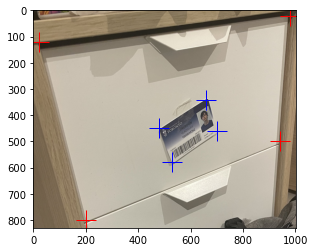

In [2]:
q1im = plt.imread("question1.jpg")

# Drawer door approx vertices
plt.plot(20, 120, marker="+", markersize=20, c="r")
plt.plot(200, 800, marker="+", markersize=20, c="r")
plt.plot(980, 20, marker="+", markersize=20, c="r")
plt.plot(940, 500, marker="+", markersize=20, c="r")

# Card approx vertices
plt.plot(480, 450, marker="+", markersize=20, c="b")
plt.plot(530, 580, marker="+", markersize=20, c="b")
plt.plot(660, 340, marker="+", markersize=20, c="b")
plt.plot(700, 460, marker="+", markersize=20, c="b")

plt.imshow(q1im)

In [3]:
# Find homography H
src = 0, 0
dst = 480, 450
row0 = np.array([src[0], src[1], 1, 0, 0, 0, -dst[0]*src[0], -dst[0]*src[1], -dst[0]])
row1 = np.array([0, 0, 0, src[0], src[1], 1, -dst[1]*src[0], -dst[1]*src[1], -dst[1]])

src = 0, 5.397
dst = 530, 580
row2 = np.array([src[0], src[1], 1, 0, 0, 0, -dst[0]*src[0], -dst[0]*src[1], -dst[0]])
row3 = np.array([0, 0, 0, src[0], src[1], 1, -dst[1]*src[0], -dst[1]*src[1], -dst[1]])

src = 8.56, 0
dst = 660, 340
row4 = np.array([src[0], src[1], 1, 0, 0, 0, -dst[0]*src[0], -dst[0]*src[1], -dst[0]])
row5 = np.array([0, 0, 0, src[0], src[1], 1, -dst[1]*src[0], -dst[1]*src[1], -dst[1]])

src = 8.56, 5.397 # Length of card 8.56cm, Width of card 5.397cm
dst = 700, 460
row6 = np.array([src[0], src[1], 1, 0, 0, 0, -dst[0]*src[0], -dst[0]*src[1], -dst[0]])
row7 = np.array([0, 0, 0, src[0], src[1], 1, -dst[1]*src[0], -dst[1]*src[1], -dst[1]])

A = np.concatenate((row0, row1, row2, row3, row4, row5, row6, row7)).reshape((8, 9))
w, v = np.linalg.eig(A.T @ A)
h = v[:,np.argmin(w)]
H = h.reshape(3, 3)

print(H)

[[-4.53475743e-02 -1.87783654e-02 -7.27963975e-01]
 [ 1.25567081e-02 -4.17049204e-02 -6.82466226e-01]
 [-2.03888320e-05 -8.92083900e-06 -1.51659161e-03]]


In [4]:
# Apply inverse homography to untransform the drawer
top_left = np.linalg.inv(H) @ np.array([20, 120, 1])
top_left = top_left[0:2] / top_left[2]

bottom_left = np.linalg.inv(H) @ np.array([200, 800, 1])
bottom_left = bottom_left[0:2] / bottom_left[2]

top_right = np.linalg.inv(H) @ np.array([980, 20, 1])
top_right = top_right[0:2] / top_right[2]

bottom_right = np.linalg.inv(H) @ np.array([940, 500, 1])
bottom_right = bottom_right[0:2] / bottom_right[2]

# Approximate length and width once untransformed
length = np.mean((np.linalg.norm(top_left - top_right),
                np.linalg.norm(bottom_left - bottom_right)))
width = np.mean((np.linalg.norm(top_left - bottom_left), 
                np.linalg.norm(top_right - bottom_right)))
                
print("Approx length of drawer door is", length, "cm")
print("Approx width of drawer door is", width, "cm")

Approx length of drawer door is 38.46130025618346 cm
Approx width of drawer door is 22.15093271786646 cm


# Question 2

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [10]:
# Get images
ls1 = plt.imread("landscape_1.jpg")
ls2 = plt.imread("landscape_2.jpg")

# Get descriptors
sift = cv.xfeatures2d.SIFT_create()
key_ls1, desc_ls1 = sift.detectAndCompute(ls1, None) # Extract SIFT descriptors
key_ls2, desc_ls2 = sift.detectAndCompute(ls2, None) # Extract SIFT descriptors

# Get matches
matcher = cv.DescriptorMatcher.create(3) # BRUTEFORCE_L1 matcher
matches = matcher.knnMatch(desc_ls1, desc_ls2, k=2) # Select top 2 best matches
best_matches = [] # Keep best matches
for m, n in matches:
    if m.distance < 0.7*n.distance:
        best_matches.append(m)
best_matches = np.array(best_matches)

# Get matched points
src_pts = np.float32([key_ls1[m.queryIdx].pt for m in best_matches])
dst_pts = np.float32([key_ls2[m.trainIdx].pt for m in best_matches])

In [17]:
# RANSAC to find best homography
best_inliers = 0
best_H = np.zeros((3, 3))
for i in range(1000):
    # Choose 4 random points
    pts = np.random.choice(range(src_pts.shape[0]), size=4, replace=False)

    # Find homography H
    src = src_pts[pts[0]]
    dst = dst_pts[pts[0]]
    row0 = np.array([src[0], src[1], 1, 0, 0, 0, -dst[0]*src[0], -dst[0]*src[1], -dst[0]])
    row1 = np.array([0, 0, 0, src[0], src[1], 1, -dst[1]*src[0], -dst[1]*src[1], -dst[1]])

    src = src_pts[pts[1]]
    dst = dst_pts[pts[1]]
    row2 = np.array([src[0], src[1], 1, 0, 0, 0, -dst[0]*src[0], -dst[0]*src[1], -dst[0]])
    row3 = np.array([0, 0, 0, src[0], src[1], 1, -dst[1]*src[0], -dst[1]*src[1], -dst[1]])

    src = src_pts[pts[2]]
    dst = dst_pts[pts[2]]
    row4 = np.array([src[0], src[1], 1, 0, 0, 0, -dst[0]*src[0], -dst[0]*src[1], -dst[0]])
    row5 = np.array([0, 0, 0, src[0], src[1], 1, -dst[1]*src[0], -dst[1]*src[1], -dst[1]])

    src = src_pts[pts[3]]
    dst = dst_pts[pts[3]]
    row6 = np.array([src[0], src[1], 1, 0, 0, 0, -dst[0]*src[0], -dst[0]*src[1], -dst[0]])
    row7 = np.array([0, 0, 0, src[0], src[1], 1, -dst[1]*src[0], -dst[1]*src[1], -dst[1]])

    A = np.concatenate((row0, row1, row2, row3, row4, row5, row6, row7)).reshape((8, 9))
    w, v = np.linalg.eig(A.T @ A)
    h = v[:,np.argmin(w)]
    H = h.reshape(3, 3)

    # Find inliers
    inliers = 0
    for ix in range(src_pts.shape[0]):
        src = src_pts[ix]
        dst = dst_pts[ix]
        new = H @ np.array([src[0], src[1], 1])
        new = new[0:2] / new[2]
        if (np.linalg.norm(new - dst) < 0.5):
            inliers += 1

    # Check if inlier count beats best inlier count
    if best_inliers < inliers:
        best_inliers = inliers
        best_H = H
print(best_inliers / src_pts.shape[0])
print(best_H)

0.868995633187773
[[ 5.06972561e-03 -4.66047701e-05 -9.92504848e-01]
 [ 2.92332056e-04  4.99468927e-03 -1.21907192e-01]
 [ 8.01289208e-07  8.75134834e-08  4.69321795e-03]]


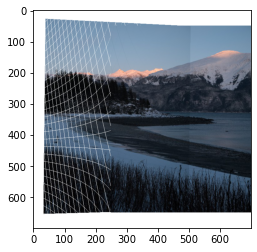

In [18]:
# Create final image with ls2
ls = np.concatenate((np.ones((ls2.shape[0], 250, ls2.shape[2])), ls2 / 255), axis=1)
ls = np.concatenate((np.ones((50, ls.shape[1], ls.shape[2])), ls), axis=0)
ls = np.concatenate((ls, np.ones((50, ls.shape[1], ls.shape[2]))), axis=0)

# Apply homography on ls1 and add to final image
for w in range(ls1.shape[0]):
    for h in range(ls1.shape[1]):
        new = H @ np.array([h, w, 1])
        new_w, new_h = np.round(new[0:2] / new[2]).astype(int)
        ls[new_h + 50, new_w + 250] = ls1[w, h] / 255

plt.imshow(ls)

# Question 3

a) 
$\begin{bmatrix}
721.5px & 0 & 609.6px\\
0 & 721.5px & 127.9px\\
0 & 0 & 1
\end{bmatrix}$

b) $Y=-170cm$


c) 
1. $\begin{bmatrix}
\frac{1}{721.5px} & 0 & -\frac{609.6}{721.5}\\
0 & \frac{1}{721.5px} & -\frac{127.9}{721.5}\\
0 & 0 & 1
\end{bmatrix}\begin{bmatrix}
xpx\\
ypx\\
1
\end{bmatrix}=\begin{bmatrix}
\hat{X}\\
\hat{Y}\\
1
\end{bmatrix}$

2. $-\frac{170cm}{\hat{Y}}\begin{bmatrix}
\hat{X}\\
\hat{Y}\\
1
\end{bmatrix}=\begin{bmatrix}
Xcm\\
Ycm\\
Zcm
\end{bmatrix}=\begin{bmatrix}
Xcm\\
-170cm\\
Zcm
\end{bmatrix}$

# Question 4

To get disparity:
1. given pixel $(x_l,y_l)$, get patch $I_{patch_l}$
2. get match $\hat{x_r} = argmin_{x_r}\Sigma_x\Sigma_y(I_{patch_l}(x_l, y_l) - I_{patch_r}(x_r, y_r))^2$ where $x_r \in [0, L]$
3. return disparity $\hat{x_r}-x_l$

$O(LP^2)$ per pixel, where $L$ is length of camera image, $P$ is dimention of patch

To get depth:
1. given pixel $(x_l,y_l)$, find disparity $\hat{x_r}-x_l$, return depth $\frac{f*T}{\hat{x_r}-x_l}$
